# Application d'un modèle de régression linéaire sur un dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

In [2]:
data = sns.load_dataset('tips')  # On récupère ici le dataset 'tips' de seaborn
data.head(3)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3


### On veut determiner s'il existe une corrélation entre les pourboires ('tip') et les données des autres colonnes ('total_bill', 'sex', 'smoker', 'day', 'time' et 'size').

In [3]:
y = data['tip']                  # Le vecteur y (variable expliquée) correspond à la colonne 'tip'
X = data.drop(columns=['tip'])   # La matrice X (variables explicatives) correspond aux autres colonnes

### On entraîne notre modèle avec 70% des données du dataset et on le valide avec les 30% restants : <br> - On entraîne notre modèle avec $y_{train}$ en fonction de $X_{train}$ <br> - On valide notre modèle avec $y_{test}$ en fonction de $X_{test}$

In [4]:
# La fonction train_test_split() permet de créer X_train, X_test, y_train et y_test automatiquement

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

### Les colonnes 'sex', 'smoker',	'day' et	'time' contiennent des données catégorielles. On doit donc les représenter ordinalement pour pouvoir appliquer un modèle de régression linéaire dessus.
### Voyont la méthode 'get_dummies( )' :

In [5]:
print(X_train[["sex","smoker","day","time"]].nunique())  # Cette commande nous donne le nombre de valeurs uniques dans les colonnes catégorielles

X_train_dummies = pd.get_dummies(X_train)  # Pour chaque colonne catégorielle, ont créé un nombre de colonnes égal au nombre de valeurs uniques qu'elle contient.
X_test_dummies = pd.get_dummies(X_test)    # Si la ligne contient cette valeur, on lui donne la valeur 1, sinon 0.

sex       2
smoker    2
day       4
time      2
dtype: int64


In [6]:
X_train.sample(3)  # Avant 'get_dummies'

,total_bill,sex,smoker,day,time,size
215,12.90,Female,Yes,Sat,Dinner,2
3,23.68,Male,No,Sun,Dinner,2
121,13.42,Female,No,Thur,Lunch,2


In [7]:
X_train_dummies.sample(3) # Après 'get_dummies'

,total_bill,size,sex_Male,sex_Female,smoker_Yes,smoker_No,day_Thur,day_Fri,day_Sat,day_Sun,time_Lunch,time_Dinner
75,10.51,2,1,0,0,1,0,0,1,0,0,1
149,7.51,2,1,0,0,1,1,0,0,0,1,0
127,14.52,2,0,1,0,1,1,0,0,0,1,0


### Maintenant qu'on a remplacé les données catégorielles en données ordinales, on peut entrainer notre modèle linéaire.

In [8]:
lr = LinearRegression()  # On utilise un modèle linéaire

In [9]:
lr_dummies = lr.fit(X_train_dummies, y_train) # On entraine le modèle avec y_train en fonction de X_train_dummies

In [10]:
lr_dummies.score(X_test_dummies, y_test)  # On récupère le R^2 de notre modèle en le testant avec y_test en fonction de X_test_dummies

0.4927168304111852

### Afin d'améliorer les performances de notre modèle et de minimiser la loss function, il est intéressant de le scaler les données numériques entre 0 et 1. <br> Créons une méthode pour le faire automatiquement.

In [11]:
# On scale les colonnes numériques de notre dataset

def valeurs_numeriques(X_train, X_test, model):                                # On précise à notre fonction le modèle de scaling à utiliser
    columns = X_test._get_numeric_data().columns.values.tolist()               # On récupère les colonnes numériques sous forme de liste
    model.fit(X_train[columns])                                                # ON FIT LE MODELE AVEC LES DONNEES D'ENTRAINEMENT ET NON DE TEST POUR EVITER LE DATALEAKAGE
    df = pd.DataFrame(model.transform(X_test[columns]))                        # On tranforme notre modèle et on le converti en dataframe
    return df.rename(columns={i:f'{columns[i]}' for i in range(len(columns))}) # On return le dataframe (on renomme les colonnes)

### Voyont la méthode 'OneHotEncoder( )' pour transformer les valeurs catégorielles en valeurs ordinales :

In [12]:
ohe = OneHotEncoder()  # Méthode alternative à get_dummies() pour transformer les valeurs catégorielles en valeurs ordinales

In [13]:
# On change les valeurs des colonnes catégorielles de notre dataset en valeurs ordinales

def valeurs_categorielles(X_train, X_test):
    columns = list(set(X.columns)-set(X_test._get_numeric_data().columns))   # On récupère les colonnes catégorielles sous forme de liste
    ohe.fit(X_train[columns])                                                # ON FIT LE MODELE AVEC LES DONNEES D'ENTRAINEMENT ET NON DE TEST POUR EVITER LE DATALEAKAGE
    return pd.DataFrame.sparse.from_spmatrix(ohe.transform(X_test[columns])) # On tranforme notre modèle et on le converti en dataframe

### Créons une méthode créant un dataset scalé et avec uniquement des valeurs numériques/ordinales :

In [14]:
# On concatène les colonnes ordinales et numériques après scaling

def scaler(X_train, X_test, scaler):
    return pd.concat([valeurs_categorielles(X_train, X_test), valeurs_numeriques(X_train, X_test, scaler)], axis=1)

### Appliquons notre méthode sur le dataset avec le modèle 'MinMaxScaler( )' :

In [15]:
X_train_mms = scaler(X_train, X_train, MinMaxScaler())  # On scale X_train
X_test_mms = scaler(X_train, X_test, MinMaxScaler())    # On scale X_test

In [16]:
X_test[['total_bill', 'size']].head(3) # Avant scaling

,total_bill,size
119,24.08,4
184,40.55,2
104,20.92,2


In [17]:
X_test_mms[['total_bill', 'size']].head(3) # Après scaling

,total_bill,size
0,0.430484,0.6
1,0.817285,0.2
2,0.356271,0.2


### Maintenant qu'on a remplacé les données catégorielles en données ordinales et scalé les données numériques, on peut entrainer notre modèle linéaire.

In [18]:
lr_mms = lr.fit(X_train_mms, y_train)              # On entraîne le modèle avec y_train en fonction de X_train_mms
print(f'R2 = {lr_mms.score(X_test_mms, y_test)}')  # On récupère le R^2 de notre modèle en le testant avec y_test en fonction de X_test_mms

R2 = 0.4921997376663716


/root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


### Superposont sur un nuage de points les valeurs prédites par notre modèle $(y_{pred})$ et les valeurs réelles $(y_{test})$ en fonction de la colonne 'total_bill'

In [19]:
y_pred_mms = lr_mms.predict(X_test_mms)  # On calcule y_pred en appliquant la méthode 'predict()' sur notre modèle

/root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


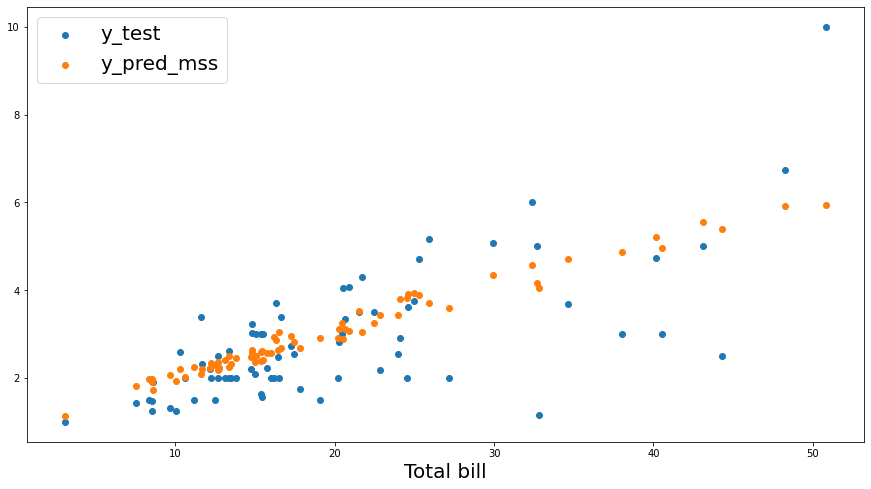

In [20]:
plt.figure(figsize=(15,8))
plt.scatter(X_test['total_bill'], y_test, label='y_test')
plt.scatter(X_test['total_bill'], y_pred_mms, label='y_pred_mss')
plt.xlabel('Total bill', fontsize=20)
plt.legend(fontsize=20)
plt.show()

### On peut représenter d'autres variables explicatives en jouant sur la taille des points, leur couleur...

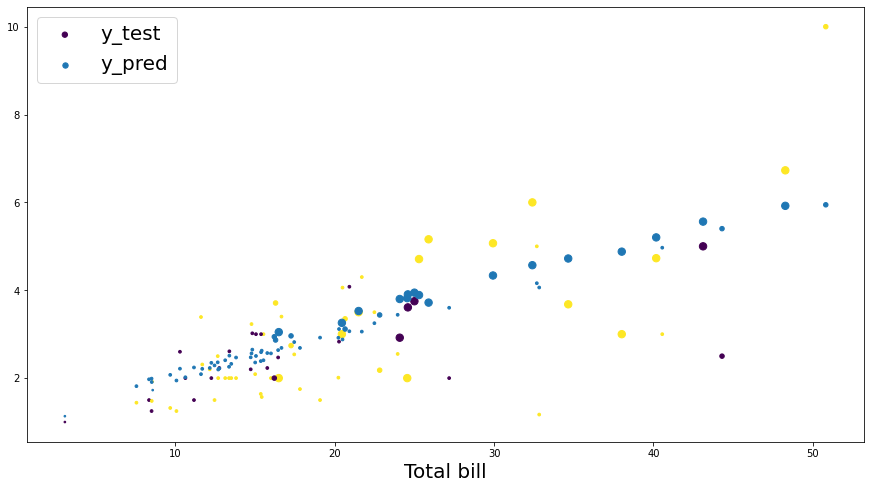

In [21]:
plt.figure(figsize=(15,8))
plt.scatter(X_test['total_bill'], y_test, label='y_test', s=np.exp(X_test['size']), c=pd.get_dummies(X_test['sex'])['Male'])
plt.scatter(X_test['total_bill'], y_pred_mms, label='y_pred', s=np.exp(X_test['size']))
plt.xlabel('Total bill', fontsize=20)
plt.legend(fontsize=20)
plt.show()

### Appliquons notre méthode avec le modèle 'StandardScaler( )' :

In [22]:
X_train_ss = scaler(X_train, X_train, StandardScaler())  # On scale X_train
X_test_ss = scaler(X_train, X_test, StandardScaler())    # On scale X_test

lr_ss = lr.fit(X_train_ss, y_train)              # On entraîne le modèle avec y_train en fonction de X_train_ss
print(f'R2 = {lr_ss.score(X_test_ss, y_test)}')  # On récupère le R^2 de notre modèle en le testant avec y_test en fonction de X_test_ss

R2 = 0.4927168304111851


/root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [23]:
y_pred_ss = lr_mms.predict(X_test_ss)  # On calcule y_pred en appliquant la méthode 'predict()' sur notre modèle

/root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/root/.pyenv/versions/3.8.12/envs/simplon/lib/python3.8/site-packages/sklearn/utils/validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


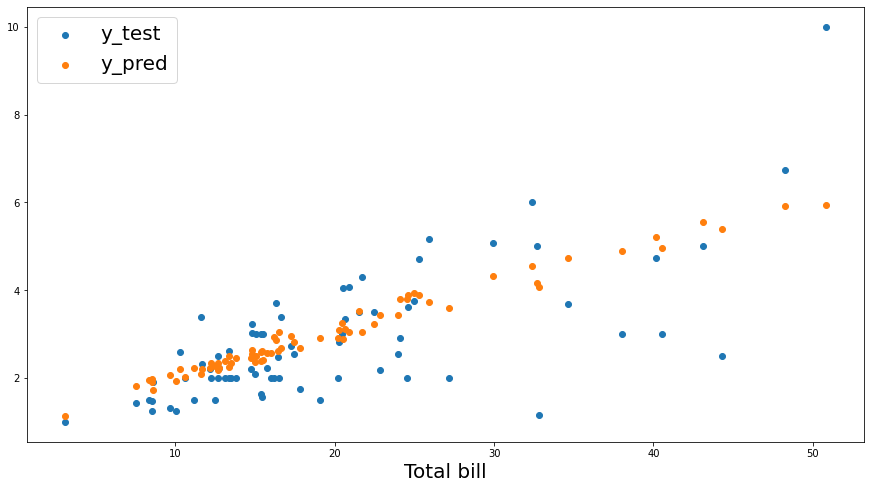

In [24]:
plt.figure(figsize=(15,8))
plt.scatter(X_test['total_bill'], y_test, label='y_test')
plt.scatter(X_test['total_bill'], y_pred_ss, label='y_pred')
plt.xlabel('Total bill', fontsize=20)
plt.legend(fontsize=20)
plt.show()

### Traçons la distribution des erreurs

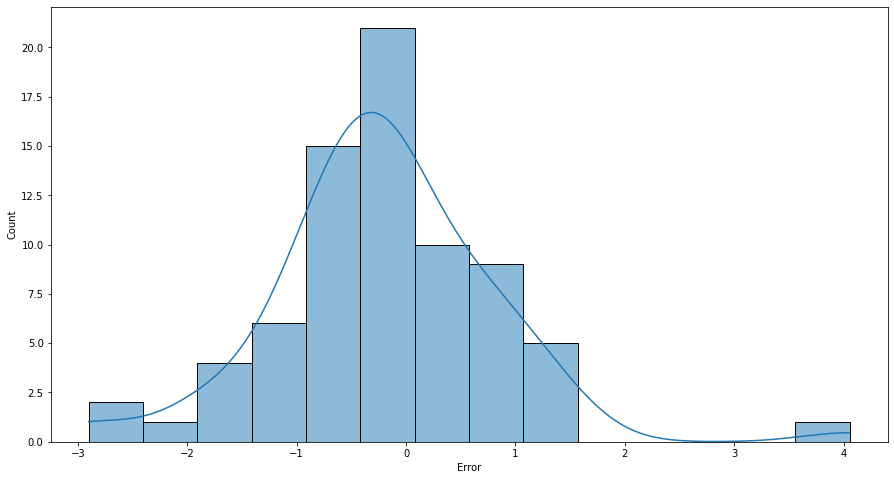

In [25]:
y_error = y_test - y_pred_mms   # L'erreur correspond à la différence entre la valeur réelle et la valeur prédite

plt.figure(figsize=(15,8))
sns.histplot(y_error, kde=True)
plt.xlabel('Error')
plt.show()